In [1]:
from dotenv import load_dotenv
from langchain_community.agent_toolkits import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [3]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import HumanMessage

from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

from langgraph.prebuilt import create_react_agent

polygon = PolygonAPIWrapper()
toolkit = PolygonToolkit.from_polygon_api_wrapper(polygon)
polygon_tools = toolkit.get_tools()
market_research_tools = [YahooFinanceNewsTool()] + polygon_tools
market_research_agent = create_react_agent(
    llm,
    tools= market_research_tools,
    prompt='You are a market researcher. Provide fact only not options'
)

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = market_research_agent.invoke(state)
    print(f'market_research_node: {result}')
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_research')]},
        goto='supervisor',
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
import yfinance as yf
from langchain.tools import tool

@tool
def get_stock_price(ticker: str) -> dict:
    """Given a stock ticker. return the price data for the past month"""
    stock_info = yf.download(ticker, period='1mo').to_dict()
    return stock_info


stock_research_tools = [get_stock_price]
stock_research_agent = create_react_agent(
    llm,
    tools=stock_research_tools,
    prompt='You are a market researcher. Provide fact only not options'
)

def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = stock_research_agent.invoke(state)
    print(f'stock_research_node: {result}')
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='stock_research')]},
        goto='supervisor',
    )

In [5]:
@tool
def company_research_tool(ticker: str) -> dict:
    """Given a ticker, return the financial information and SEC filings"""
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials()
    sec_filings = company_info.get_sec_filings()
    return {
        'financial_info': financial_info,
        'sec_filings': sec_filings,
    }

company_research_tools = [company_research_tool]
company_research_agent = create_react_agent(
    llm,
    tools=company_research_tools,
    prompt='You are a company researcher. Provide fact only not options'
)

def company_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = stock_research_agent.invoke(state)
    print(f'company_research_node: {result}')
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='stock_research')]},
        goto='supervisor',
    )


In [6]:
from langchain_core.prompts import PromptTemplate

analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information,
Please decide whether to buy, sell, or hold the stock.

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: MessagesState):

    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [HumanMessage(content=result.content, name='analyst')]}

In [7]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node입니다. 주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정합니다. 모든 작업이 완료되면 analyst node로 이동합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령을 반환합니다.
    """
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [8]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("company_research", company_research_node)
graph_builder.add_node("analyst", analyst_node)

In [9]:
graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
graph = graph_builder.compile()

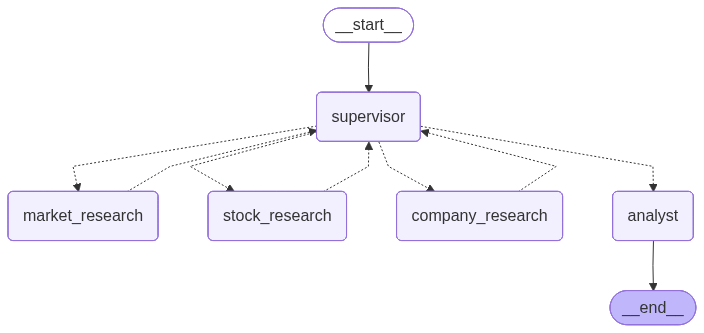

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
for chunk in graph.stream(
    {"messages": [("user", "Would you invest in Snowflake?")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Would you invest in Snowflake?
market_research_node: {'messages': [HumanMessage(content='Would you invest in Snowflake?', additional_kwargs={}, response_metadata={}, id='dd50ac85-e82f-4eab-9896-cde318a1acc7'), AIMessage(content="As an AI, I don't have personal opinions or the ability to invest. However, I can provide you with financial data and recent news related to Snowflake if you would like to evaluate its investment potential. Please let me know how you would like to proceed.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 513, 'total_tokens': 566, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_aa07c96156', 'id':

/var/folders/1c/dwy747jx7m52_6rp06qvypx40000gn/T/ipykernel_56109/2652704602.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_info = yf.download(ticker, period='1mo').to_dict()
[*********************100%***********************]  1 of 1 completed


stock_research_node: {'messages': [HumanMessage(content='Would you invest in Snowflake?', additional_kwargs={}, response_metadata={}, id='dd50ac85-e82f-4eab-9896-cde318a1acc7'), HumanMessage(content="As an AI, I don't have personal opinions or the ability to invest. However, I can provide you with financial data and recent news related to Snowflake if you would like to evaluate its investment potential. Please let me know how you would like to proceed.", additional_kwargs={}, response_metadata={}, name='market_research', id='91ab18be-c413-427d-bb19-8cd2ce01156d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_P5emjUtNMIGMjz5Lok9CxNPS', 'function': {'arguments': '{"ticker":"SNOW"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 131, 'total_tokens': 147, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_

KeyboardInterrupt: 